In [1]:
!pip install opencv-contrib-python
!pip install imutils
!pip install scikit-image

You should consider upgrading via the '/media/hoangle/Works/anaconda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/media/hoangle/Works/anaconda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/media/hoangle/Works/anaconda/bin/python -m pip install --upgrade pip' command.


In [2]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 20.04.2 LTS
Release:	20.04
Codename:	focal


In [3]:
!apt install tesseract-ocr

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [ ]:
!tesseract -v

tesseract 4.0.0-beta.1
 leptonica-1.75.3
  libgif 5.1.4 : libjpeg 8d (libjpeg-turbo 1.5.2) : libpng 1.6.34 : libtiff 4.0.9 : zlib 1.2.11 : libwebp 0.6.1 : libopenjp2 2.3.0

 Found AVX2
 Found AVX
 Found SSE


In [4]:
!pip install pillow
!pip install pytesseract
!pip install imutils

You should consider upgrading via the '/media/hoangle/Works/anaconda/bin/python -m pip install --upgrade pip' command.
  Created wheel for pytesseract: filename=pytesseract-0.3.8-py2.py3-none-any.whl size=14071 sha256=20090f3d95767f2de7cadcd2b401fc975ba133918995080fd5fbc127f4b03fa8
  Stored in directory: /home/hoangle/.cache/pip/wheels/ed/8a/c6/40c7ec06c2dd3df636832537238128a1471bf9c1b6a3a9bf40
Successfully built pytesseract
You should consider upgrading via the '/media/hoangle/Works/anaconda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/media/hoangle/Works/anaconda/bin/python -m pip install --upgrade pip' command.


In [5]:
from skimage.segmentation import clear_border
import pytesseract
import numpy as np
import imutils
import cv2
from google.colab.patches import cv2_imshow



class PyImageSearchANPR:
	def __init__(self, minAR=4, maxAR=5, debug=False):
		# store the minimum and maximum rectangular aspect ratio
		# values along with whether or not we are in debug mode
		self.minAR = minAR
		self.maxAR = maxAR
		self.debug = debug
	
	def debug_imshow(self, title, image, waitKey=False):
		# check to see if we are in debug mode, and if so, show the
		# image with the supplied title
		# return None
		if self.debug:
			cv2_imshow(image)
			# check to see if we should wait for a keypress
			if waitKey:
				cv2.waitKey(0)
	
	def locate_license_plate_candidates(self, gray, keep=5):
		# perform a blackhat morphological operation that will allow
		# us to reveal dark regions (i.e., text) on light backgrounds
		# (i.e., the license plate itself)
		rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
		cv2_imshow(rectKern)
		return None
		blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKern)
		
		self.debug_imshow("Blackhat", blackhat)
		
		squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
		light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, squareKern)
		light = cv2.threshold(light, 0, 255,
		                      cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
		self.debug_imshow("Light Regions", light)
		gradX = cv2.Sobel(
			blackhat,
			ddepth=cv2.CV_32F,
			dx=1, dy=0, ksize=-1
		)
		
		gradX = np.absolute(gradX)
		(minVal, maxVal) = (np.min(gradX), np.max(gradX))
		gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
		gradX = gradX.astype("uint8")
		self.debug_imshow("Scharr", gradX)
    
		gradX = cv2.GaussianBlur(gradX, (5, 5), 0)
		gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKern)
		thresh = cv2.threshold(gradX, 0, 255,
		cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
		self.debug_imshow("Grad Thresh", thresh)
		
		thresh = cv2.erode(thresh, None, iterations=2)
		thresh = cv2.dilate(thresh, None, iterations=2)
		self.debug_imshow("Grad Erode/Dilate", thresh)
		
		# take the bitwise AND between the threshold result and the
		# light regions of the image
		thresh = cv2.bitwise_and(thresh, thresh, mask=light)
		thresh = cv2.dilate(thresh, None, iterations=2)
		thresh = cv2.erode(thresh, None, iterations=1)
		self.debug_imshow("Final", thresh, waitKey=True)
		
		cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
		                        cv2.CHAIN_APPROX_SIMPLE)
		cnts = imutils.grab_contours(cnts)
		cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:keep]
		# return the list of contours
		
		return cnts
	
	def locate_license_plate(self, gray, candidates,
	                         clearBorder=False):
		# initialize the license plate contour and ROI
		lpCnt = None
		roi = None
		# loop over the license plate candidate contours
		for c in candidates:
			# compute the bounding box of the contour and then use
			# the bounding box to derive the aspect ratio
			(x, y, w, h) = cv2.boundingRect(c)
			ar = w / float(h)
			
			# check to see if the aspect ratio is rectangular
			if ar >= self.minAR and ar <= self.maxAR:
				# store the license plate contour and extract the
				# license plate from the grayscale image and then
				# threshold it
				lpCnt = c
				licensePlate = gray[y:y + h, x:x + w]
				roi = cv2.threshold(licensePlate, 0, 255,
				                    cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
			
        # check to see if we should clear any foreground
        # pixels touching the border of the image
        # (which typically, not but always, indicates noise)
				if clearBorder:
					roi = clear_border(roi)
        # display any debugging information and then break
        # from the loop early since we have found the license
        # plate region
				self.debug_imshow("License Plate", licensePlate)
				self.debug_imshow("ROI", roi, waitKey=True)
				break
		
		# return a 2-tuple of the license plate ROI and the contour
		# associated with it
		return (roi, lpCnt)
	
	def build_tesseract_options(self, psm=7):
		# tell Tesseract to only OCR alphanumeric characters
		alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
		options = "-c tessedit_char_whitelist={}".format(alphanumeric)
		# set the PSM mode
		options += " --psm {}".format(psm)
		# return the built options string
		return options
	
	def find_and_ocr(self, image, psm=7, clearBorder=False):
		# initialize the license plate text
		lpText = None
		# convert the input image to grayscale, locate all candidate
		# license plate regions in the image, and then process the
		# candidates, leaving us with the *actual* license plate
		gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		cv2_imshow(gray)

		candidates = self.locate_license_plate_candidates(gray)
		# print('candidates', candidates)
		return (None, None)

		(lp, lpCnt) = self.locate_license_plate(gray, candidates,
		                                        clearBorder=clearBorder)
		# only OCR the license plate if the license plate ROI is not
		# empty
		if lp is not None:
			# OCR the license plate
			options = self.build_tesseract_options(psm=psm)
			lpText = pytesseract.image_to_string(lp, config=options)
			self.debug_imshow("License Plate", lp)
		# return a 2-tuple of the OCR'd license plate text along with
		# the contour associated with the license plate region
		return (lpText, lpCnt)


ModuleNotFoundError: No module named 'google.colab'

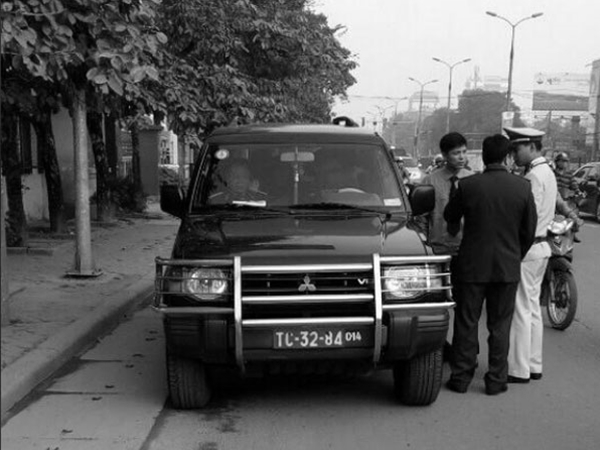

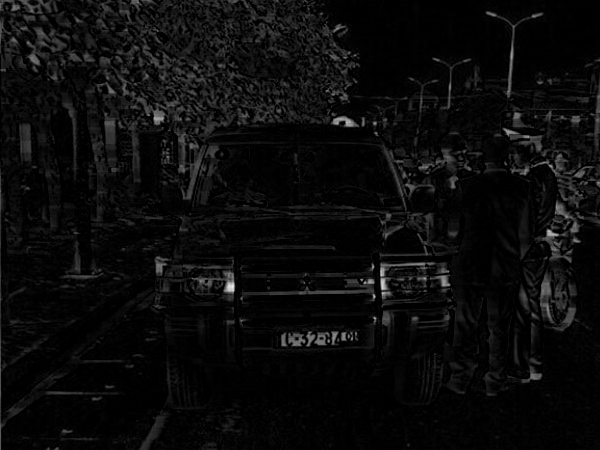

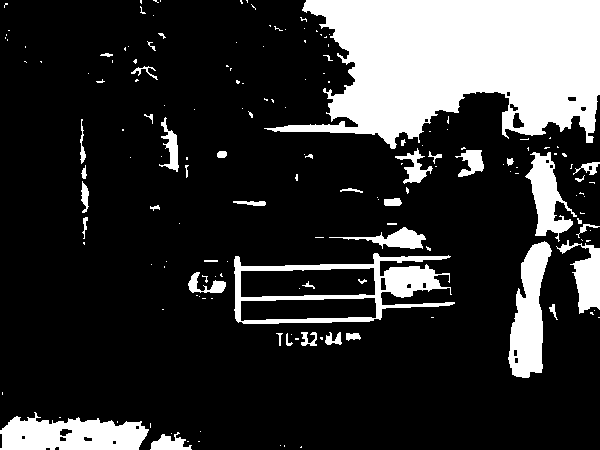

result None


In [ ]:
from skimage.segmentation import clear_border
import pytesseract
import numpy as np
import imutils
import cv2
from google.colab.patches import cv2_imshow



class PyImageSearchANPR:
	def __init__(self, minAR=4, maxAR=5, debug=False):
		# store the minimum and maximum rectangular aspect ratio
		# values along with whether or not we are in debug mode
		self.minAR = minAR
		self.maxAR = maxAR
		self.debug = debug
	
	def debug_imshow(self, title, image, waitKey=False):
		# check to see if we are in debug mode, and if so, show the
		# image with the supplied title
		# return None
		if self.debug:
			cv2_imshow(image)
			# check to see if we should wait for a keypress
			if waitKey:
				cv2.waitKey(0)
	
	def locate_license_plate_candidates(self, gray, keep=5):
		# perform a blackhat morphological operation that will allow
		# us to reveal dark regions (i.e., text) on light backgrounds
		# (i.e., the license plate itself)
		rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))

		blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKern)

		
		self.debug_imshow("Blackhat", blackhat)
		
		squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
		light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, squareKern)

		light = cv2.threshold(light, 0, 255,
		                      cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
		self.debug_imshow("Light Regions", light)
		# self.debug_imshow("light", light)
		return None

		gradX = cv2.Sobel(
			blackhat,
			ddepth=cv2.CV_32F,
			dx=1, dy=0, ksize=-1
		)
		
		gradX = np.absolute(gradX)
		(minVal, maxVal) = (np.min(gradX), np.max(gradX))
		gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
		gradX = gradX.astype("uint8")
		self.debug_imshow("Scharr", gradX)
    
		gradX = cv2.GaussianBlur(gradX, (5, 5), 0)
		gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKern)
		thresh = cv2.threshold(gradX, 0, 255,
		cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
		self.debug_imshow("Grad Thresh", thresh)
		
		thresh = cv2.erode(thresh, None, iterations=2)
		thresh = cv2.dilate(thresh, None, iterations=2)
		self.debug_imshow("Grad Erode/Dilate", thresh)
		
		# take the bitwise AND between the threshold result and the
		# light regions of the image
		thresh = cv2.bitwise_and(thresh, thresh, mask=light)
		thresh = cv2.dilate(thresh, None, iterations=2)
		thresh = cv2.erode(thresh, None, iterations=1)
		self.debug_imshow("Final", thresh, waitKey=True)
		
		cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
		                        cv2.CHAIN_APPROX_SIMPLE)
		cnts = imutils.grab_contours(cnts)
		cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:keep]
		# return the list of contours
		
		return cnts
	
	def locate_license_plate(self, gray, candidates,
	                         clearBorder=False):
		# initialize the license plate contour and ROI
		lpCnt = None
		roi = None
		# loop over the license plate candidate contours
		for c in candidates:
			# compute the bounding box of the contour and then use
			# the bounding box to derive the aspect ratio
			(x, y, w, h) = cv2.boundingRect(c)
			ar = w / float(h)
			
			# check to see if the aspect ratio is rectangular
			if ar >= self.minAR and ar <= self.maxAR:
				# store the license plate contour and extract the
				# license plate from the grayscale image and then
				# threshold it
				lpCnt = c
				licensePlate = gray[y:y + h, x:x + w]
				roi = cv2.threshold(licensePlate, 0, 255,
				                    cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
			
        # check to see if we should clear any foreground
        # pixels touching the border of the image
        # (which typically, not but always, indicates noise)
				if clearBorder:
					roi = clear_border(roi)
        # display any debugging information and then break
        # from the loop early since we have found the license
        # plate region
				self.debug_imshow("License Plate", licensePlate)
				self.debug_imshow("ROI", roi, waitKey=True)
				break
		
		# return a 2-tuple of the license plate ROI and the contour
		# associated with it
		return (roi, lpCnt)
	
	def build_tesseract_options(self, psm=7):
		# tell Tesseract to only OCR alphanumeric characters
		alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
		options = "-c tessedit_char_whitelist={}".format(alphanumeric)
		# set the PSM mode
		options += " --psm {}".format(psm)
		# return the built options string
		return options
	
	def find_and_ocr(self, image, psm=7, clearBorder=False):
		# initialize the license plate text
		lpText = None
		# convert the input image to grayscale, locate all candidate
		# license plate regions in the image, and then process the
		# candidates, leaving us with the *actual* license plate
		gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		cv2_imshow(gray)

		candidates = self.locate_license_plate_candidates(gray)
		# print('candidates', candidates)
		return (None, None)

		(lp, lpCnt) = self.locate_license_plate(gray, candidates,
		                                        clearBorder=clearBorder)
		# only OCR the license plate if the license plate ROI is not
		# empty
		if lp is not None:
			# OCR the license plate
			options = self.build_tesseract_options(psm=psm)
			lpText = pytesseract.image_to_string(lp, config=options)
			self.debug_imshow("License Plate", lp)
		# return a 2-tuple of the OCR'd license plate text along with
		# the contour associated with the license plate region
		return (lpText, lpCnt)


from imutils import paths
import argparse
import imutils
import cv2

from google.colab.patches import cv2_imshow

def cleanup_text(text):
	# strip out non-ASCII text so we can draw the text on the image
	# using OpenCV
	return "".join([c if ord(c) < 128 else "" for c in text]).strip()

# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--input", required=True,
# 	help="path to input directory of images")
# ap.add_argument("-c", "--clear-border", type=int, default=-1,
# 	help="whether or to clear border pixels before OCR'ing")
# ap.add_argument("-p", "--psm", type=int, default=7,
# 	help="default PSM mode for OCR'ing license plates")
# ap.add_argument("-d", "--debug", type=int, default=-1,
# 	help="whether or not to show additional visualizations")
# args = vars(ap.parse_args())

anpr = PyImageSearchANPR(debug=1 > 0)
# # grab all image paths in the input directory
# imagePaths = sorted(list(paths.list_images(args["input"])))
imagePaths = ['/content/sample_data/bien_1.webp']
imagePaths = ['/content/sample_data/bien_do.jpg']
# imagePaths = ['/content/sample_data/bien_xanh_2.jpg']

# imagePaths = ['/content/sample_data/bien_xanh.jpg']



# loop over all image paths in the input directory
for imagePath in imagePaths:
	# load the input image from disk and resize it
	image = cv2.imread(imagePath)

	image = imutils.resize(image, width=600)
	# cv2_imshow(image)
	# break
	# apply automatic license plate recognition
	(lpText, lpCnt) = anpr.find_and_ocr(image, psm=27,
		clearBorder=0 > 0)
	print('result', lpCnt)
 
	# only continue if the license plate was successfully OCR'd
	if lpText is not None and lpCnt is not None:
		# fit a rotated bounding box to the license plate contour and
		# draw the bounding box on the license plate
		# box = cv2.boxPoints(cv2.minAreaRect(lpCnt))
		# box = box.astype("int")
		# cv2.drawContours(image, [box], -1, (0, 255, 0), 2)
		# # compute a normal (unrotated) bounding box for the license
		# # plate and then draw the OCR'd license plate text on the
		# # image
		# (x, y, w, h) = cv2.boundingRect(lpCnt)
		# cv2.putText(image, cleanup_text(lpText), (x, y - 15),
		# 	cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)
		# # show the output ANPR image
		# print("[INFO] {}".format(lpText))
		# cv2_imshow(image)
		# cv2.waitKey(0)
		pass